# Load Data.

In [8]:
# Load data.
import pickle

if 1:
    with open('OS_all_M_T_title.p','rb') as f:
        data = pickle.load(f)
    M_OS = data[0]
    T_OS = data[1]
    OS_titles = data[2]
    corpus_category = data[3]
    assert len(corpus_category)==len(OS_titles)
    #print("\n".join(OS_titles[:10]))
    
    corpus_type = ['PHYS','CHEM','BIOL']
    for i in range(len(OS_titles)):
        OS_titles[i] = corpus_type[int(corpus_category[i])] + ' ' + OS_titles[i]

import numpy as np
import matplotlib.pyplot as plt

# iPywidgets for interactivity


In [9]:
# Key functions for generating curriculum.

def find_pdist (M):
    # M is number of points (row) x dimensions (column)
    pdist = np.sqrt(np.sum((M[None, :] - M[:, None])**2, -1))
    return pdist

def find_path_start_end (M, starting_point, ending_point, prob=1.0, pathlen=0):
    # input: M is number of points (row) x dimensions (column)
    # output: good_path = list of length N
    # prob = Probability for accepting and rejecting the next point.
    #        (trying to avoid local min, c.f., simulated annealing).
    # prob = 1.0 (always accept the next closest point)

    # pdist = N x N 
    pdist = find_pdist(M)

    good_path = list()
    good_path.append(starting_point)

    N, _ = pdist.shape

    # Figure out how long path should be, based on the pathlen parameter.
    if pathlen>0: # pathlen was specified, so use that.
        if pathlen>N: # but there is a limit of N.
            pathlen = N
    else: # pathlen was not specified, so get the full path.
        pathlen = N

    for i in range(pathlen-1):
        curr_pt = good_path[i]

        dist_from_curr_pt = pdist[curr_pt,:]
        # index of points in ascending order of distances.
        idx = np.argsort(dist_from_curr_pt).tolist() # ordered index values.
        for j in good_path:
            idx.remove(j) # remove index that was already visited.

        # now index should only contain points that were unvisited, in 
        # an ascending order of distances from the current point.

        # Now, roll dice, and probabilistically accept points.
        p = np.random.rand(len(idx)) < prob
        if any(p):
            #print(np.argwhere(p==True)[0])
            # Find the first index of True value.
            j = idx[np.argwhere(p==True)[0][0]]
        else: # if no points were selected, choose a random point.
            j = idx[np.random.randint(len(idx))]

        good_path.append(j)
        if j==ending_point: 
            # if ending_point was specified by the user, and if it was reached,
            # end the loop early.
            break
    #if pathlen==N:
    #    assert all(np.sort(good_path)==range(pathlen))
    if ending_point>0: 
        # if ending_point was specified, but never reached, return empty.
        if ending_point not in good_path:
            good_path = list()
    return good_path

def find_sig_features (M, path, pathlen=0):
    # Find features (column indices) with significance within path.
    # The significance could be high values or high variance, 
    assert len(path)>0 # path should not be empty.
    assert len(path)>=pathlen
    if pathlen==0:
        pathlen = len(path)

    M_sliced = M[path[:pathlen],:]

    topN = 5
    sig_features = list()

    # Which features have the largest mean value?
    M_summary = np.mean(M_sliced,axis=0)
    idx = np.argsort(M_summary)[::-1][:topN]
    for i in idx:
        sig_features.append(i)

    # Which features have the largest variance value?
    #M_summary = np.var(M_sliced,axis=0)
    #idx = np.argsort(M_summary)[::-1][:topN]
    #sig_features.append(idx)

    # We could have multiple strategies for finding the significant
    # features, and then find which index appears most often.
    # Not implemented.
    return sig_features

def plot_horizontal_bar (results, category_names):
    # Taken from matplotlib example.
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(8,0.5*len(results)))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=1,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        #for y, (x, c) in enumerate(zip(xcenters, widths)):
        #    ax.text(x, y, str(int(c)), ha='center', va='center',
        #            color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='large')

    return fig, ax


In [10]:
import ipywidgets as widgets

dropdown_options = [x for x in OS_titles]
dropdown_options.insert(0,'Select One')

pt0_dropdown = widgets.Dropdown(
    options=dropdown_options,
    value=dropdown_options[0],
    description='Starting Point:',
    disabled=False,
)

pt1_dropdown = widgets.Dropdown(
    options=dropdown_options,
    value=dropdown_options[0],
    description='Ending Point:',
    disabled=False,
)

prob_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.1,
    description='Probability:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

pathlen_slider = widgets.IntSlider(
    value=50,
    min=5,
    max=500,
    step=5,
    description='Pathlength:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

counter_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=10,
    step=1,
    description='Counter (number of examples):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

display(pt0_dropdown)
display(pt1_dropdown)
display(prob_slider)
display(pathlen_slider)
display(counter_slider)

Dropdown(description='Starting Point:', options=('Select One', 'PHYS \ufeff1.0 Introduction to Science and the…

Dropdown(description='Ending Point:', options=('Select One', 'PHYS \ufeff1.0 Introduction to Science and the R…

FloatSlider(value=0.5, continuous_update=False, description='Probability:', max=1.0, readout_format='.1f')

IntSlider(value=50, continuous_update=False, description='Pathlength:', max=500, min=5, step=5)

IntSlider(value=3, continuous_update=False, description='Counter (number of examples):', max=10, min=1)

pt0 (start):  BIOL ﻿14.3 Basics of DNA Replication
pt1 (endng):  PHYS ﻿18.3 Coulomb's Law
Probability =  0.2
Pathlength =  50
Interesting Path 1


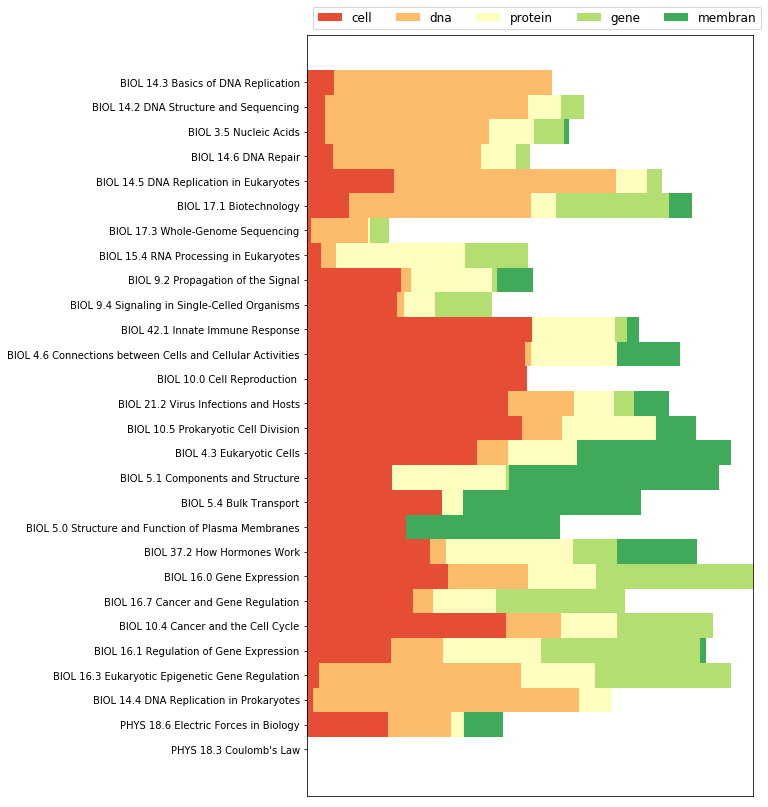

Interesting Path 2


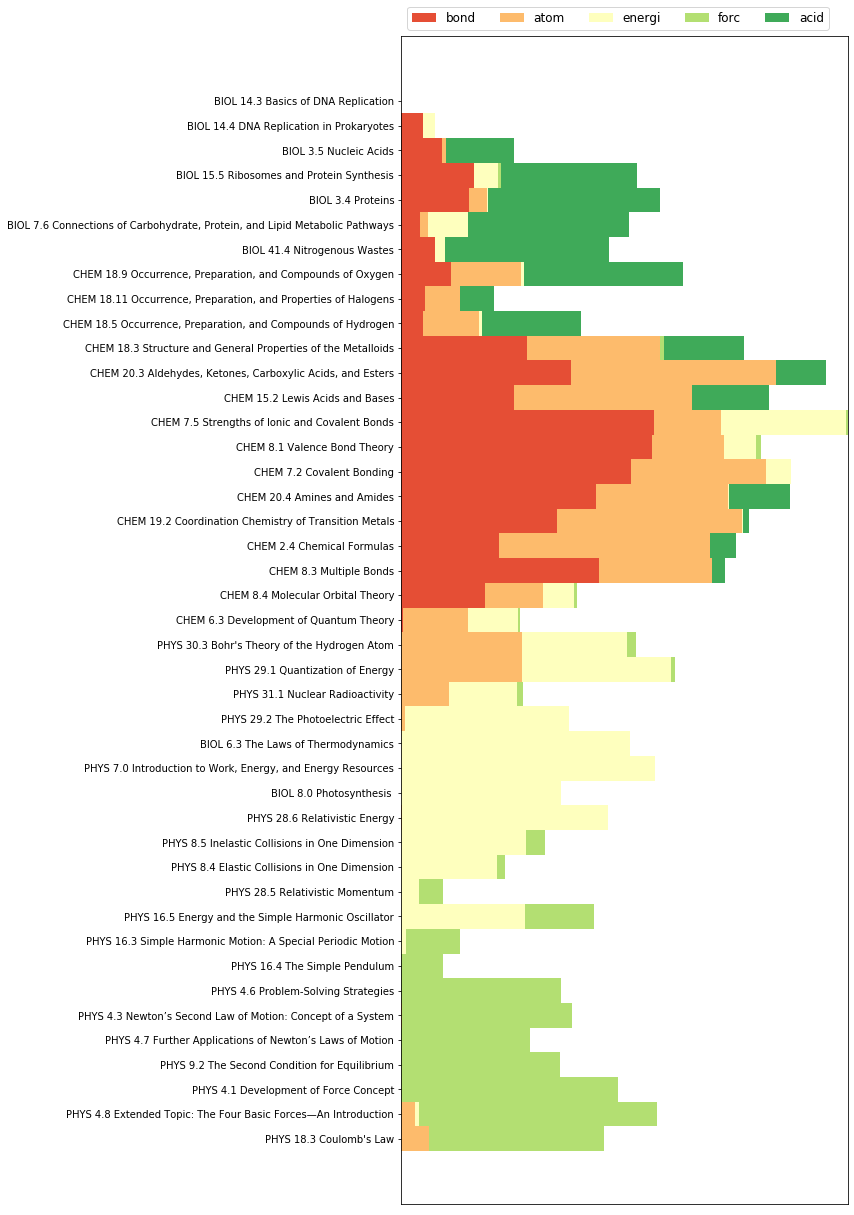

Interesting Path 3


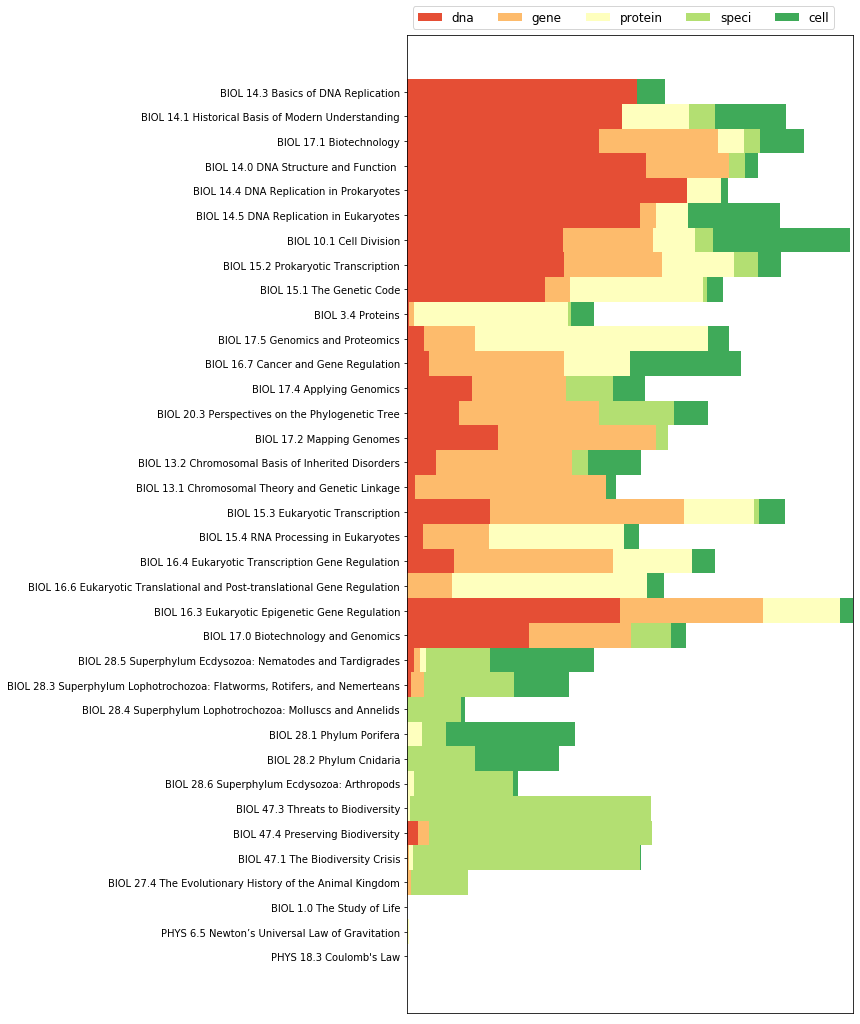

Interesting Path 4


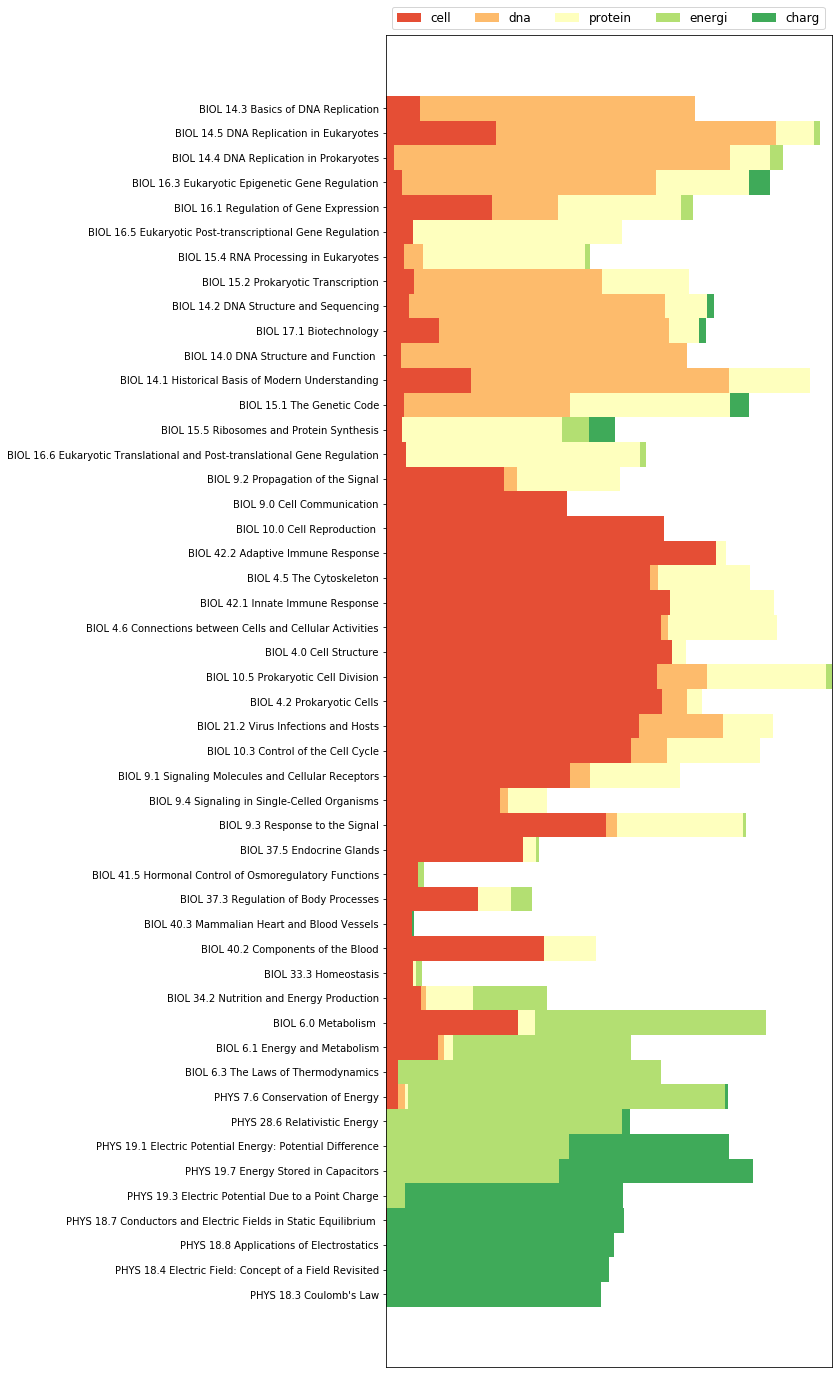

Interesting Path 5


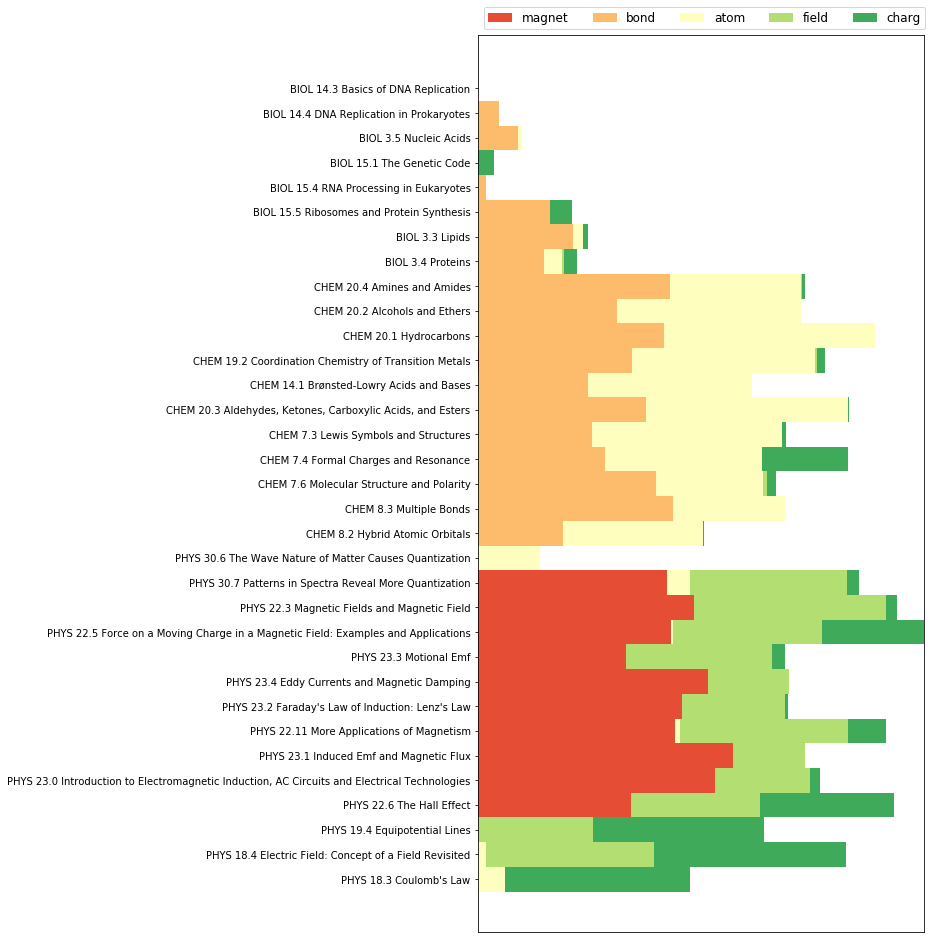

In [11]:

# Subtract 1 (because of "Select One" option).
pt0 = dropdown_options.index(pt0_dropdown.value)-1
pt1 = dropdown_options.index(pt1_dropdown.value)-1
prob = prob_slider.value
pathlen = pathlen_slider.value
counter_max = counter_slider.value

print("pt0 (start): ", OS_titles[pt0])
print("pt1 (endng): ", OS_titles[pt1])
print("Probability = ", prob)
print("Pathlength = ", pathlen)

counter = 0
max_trials = 10000 # number of tries.
interesting_path = list()
for i in range(max_trials):
    if (counter>=counter_max):
        break
    path = find_path_start_end (M_OS,pt0,pt1,prob=prob)
    if len(path)>0 and len(path)<=pathlen:
        interesting_path.append(path)
        counter = counter + 1
        print("Interesting Path %d"%counter)
        sig_features = find_sig_features(M_OS,path)
        sig_features = np.array(sig_features)
        sections = []
        for i in path:
            sections.append(OS_titles[i])
        terms = []
        for i in sig_features:
            terms.append(T_OS[i])

        # Fill in the data structure, which would be useful for plotting.
        results = {}
        for sec in path:
            results[OS_titles[sec]] = M_OS[sec,sig_features]
        plot_horizontal_bar(results, terms)
        plt.savefig('interesting_path_%d_%d_save%d.png'%(pt0,pt1,counter),bbox_inches='tight',dpi=300)
        plt.show()
 

[480, 479, 425, 483, 482, 499, 501, 488, 458, 460, 633, 432, 461, 518, 466, 429, 434, 437, 433, 607, 490, 497, 465, 491, 493, 481, 140, 137]
[480, 481, 425, 489, 424, 450, 630, 393, 395, 389, 387, 404, 369, 319, 322, 316, 405, 399, 289, 324, 325, 311, 240, 229, 248, 230, 441, 40, 452, 227, 55, 54, 226, 119, 117, 118, 26, 23, 27, 60, 21, 28, 137]


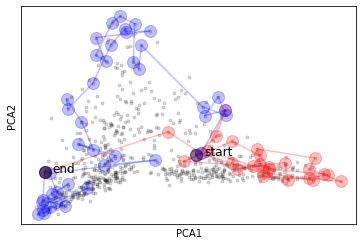

In [14]:
# Display the paths on a scatter plot.
# The code is based on plot_route_2d function.
import sklearn
from sklearn.decomposition import PCA

N, d = M_OS.shape
pca_operator = sklearn.decomposition.PCA(n_components=2)
X = pca_operator.fit_transform(M_OS)
for i in range(N): # Display all points as small dot.
    plt.plot(X[i,0],X[i,1],'.',color='k',alpha=0.15)
        
# Examine the saved examples and pick nice examples of curriculum.
path_ex = [0,1] # Manual labeling.

colors = ('r','b')

assert len(path_ex)==len(colors)
for i in range(len(path_ex)):
    c = colors[i]
    this_path = interesting_path[path_ex[i]]
    print(this_path)
    for pt in this_path:
        plt.plot(X[pt,0],X[pt,1],'.',color=c,alpha=0.25,markersize=24)
    for p1, p2 in zip(this_path[:-1], this_path[1:]):
        plt.plot([X[p1,0],X[p2,0]],[X[p1,1],X[p2, 1]],color=c,alpha=0.25)

# Include starting and end points on the plot.
plt.plot(X[this_path[0],0],X[this_path[0],1],'o',color='k',alpha=0.25,markersize=12)
plt.plot(X[this_path[-1],0],X[this_path[-1],1],'o',color='k',alpha=0.50,markersize=12)
plt.text(X[this_path[0],0] +0.025,X[this_path[0],1],'start',fontsize=12)
plt.text(X[this_path[-1],0]+0.025,X[this_path[-1],1],'end',fontsize=12)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xticks(())
plt.yticks(())

plt.savefig('example_paths_%d_%d.png'%(pt0,pt1),dpi=600)
plt.show()

# Make 3D interactive plot

In [2]:
# Save data in csv file (for easier reads).

# np.savetxt('data_xyz.csv', data_array[:,0:3], delimiter=',',fmt='%8.7f')
# np.savetxt('data_section_tfidf.csv',M_OS,delimiter=',',fmt='%8.7f')

# with open("data_titles.txt", "w") as output:
#     for row in OS_titles:
#         output.write(str(row[1:]) + '\n')

# with open("data_category.txt", "w") as output:
#     for row in corpus_category:
#         output.write(str(int(row)) + '\n')

In [3]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

data_array = TSNE(n_components=3).fit_transform(M_OS)
data_array = PCA(n_components=3).fit_transform(M_OS)

x=data_array[:,0]
y=data_array[:,1]
z=data_array[:,2]
text=np.array(OS_titles)

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [ ]:
# Create 3D plot.

idx = corpus_category==0
trace1 = go.Scatter3d(x=x[idx],y=y[idx],z=z[idx],text=text[idx],name="PHYS",mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        #color=list(range(len(idx))).reverse(),
        #colorscale='Reds',
        opacity=0.5
    ),
    hoverinfo='text'
)

idx = corpus_category==1
trace2 = go.Scatter3d(x=x[idx],y=y[idx],z=z[idx],text=text[idx],name="CHEM",mode='markers',
    marker=dict(
        size=8,
        color='rgb(0,255,0)',
        #color=list(range(len(idx))).reverse(),
        #colorscale='Greens',
        opacity=0.5
    ),
    hoverinfo='text'
)
idx = corpus_category==2
trace3 = go.Scatter3d(x=x[idx],y=y[idx],z=z[idx],text=text[idx],name="BIOL",mode='markers',
    marker=dict(
        size=8,
        color='rgb(0,0,255)',
        #color=list(range(len(idx))).reverse(),
        #colorscale='Blues',
        opacity=0.5
    ),
    hoverinfo='text'
)


data = [trace1,trace2,trace3]
layout = go.Layout(
    #width=800,
    #height=900,
    #autosize=False,
    margin=dict(t=0,b=0,l=0,r=0),
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230, 230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230, 230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230, 230)'
        ),
        aspectratio = dict(x=1, y=1, z=1),
        aspectmode = 'manual'
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)
py.offline.plot(fig, auto_open= True, filename='scatter_3D.html')